In [25]:
# Perform an analysis using LDA as topic modelling algorithm and determine parameters via an optimization approach

In [26]:
import pickle
from gensim import matutils, models
import scipy.sparse
import pandas as pd
from gensim.models import CoherenceModel

In [27]:
# Set the class of tweets specifying the correct file
f_data = pd.read_csv('../data/negative_post_rebalancing.csv')

In [28]:
# Set the proper range of dates to analyze
f_data = f_data.loc[f_data['Datetime'] >= '2022-05-12']
f_data = f_data.loc[f_data['Datetime'] <= '2022-05-18']

In [29]:
#Create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(f_data.Text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = f_data.index
tdm = data_dtm.transpose()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
# Put the term-document matrix into the gensim format,df -> sparse matrix -> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [31]:
# Gensim also requires dictionary of the  terms and their respective location in the term-document matrix
cv = pickle.load(open("../data/cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
# Function to pull out nouns from the text
from nltk import word_tokenize, pos_tag

def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [33]:
data_nouns = pd.DataFrame(f_data.Text.apply(nouns))

In [34]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said','game','discord','tweet','twitter'
                  'retweet','check','play','join','world','thing','coinnews']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.Text)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,abbath,ability,abode,abounds,absolute,accenture,access,account,accounts,accumulate,...,zieneshisu,ziyade,znga,zombie,zoo,zoom,zuck,zuckerbergartnet,zuckerbergconcept,zuo
21197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [36]:
# Function to pull out adjectives from a string of text
def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

In [37]:
data_nouns_adj = pd.DataFrame(f_data.Text.apply(nouns_adj))

In [38]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words specifying the max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.Text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,abbath,ability,abode,abounds,absolute,abstract,accenture,access,accessible,...,zieneshisu,ziyade,znga,zombie,zoo,zoom,zuck,zuckerbergartnet,zuckerbergconcept,zuo
21197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [40]:
ldana = models.LdaModel(corpus=corpusna, num_topics=5, id2word=id2wordna, passes=1)
ldana.print_topics()

[(0,
  '0.019*"drop" + 0.012*"new" + 0.005*"wtf" + 0.005*"build" + 0.005*"learn" + 0.004*"image" + 0.004*"opensea" + 0.004*"pets" + 0.003*"earn" + 0.003*"server"'),
 (1,
  '0.009*"drop" + 0.006*"cybee" + 0.005*"new" + 0.005*"yeni" + 0.005*"news" + 0.004*"haber" + 0.004*"long" + 0.004*"community" + 0.004*"atlas" + 0.004*"live"'),
 (2,
  '0.007*"market" + 0.005*"future" + 0.005*"shi" + 0.005*"drop" + 0.005*"yi" + 0.005*"martians" + 0.005*"miss" + 0.005*"collection" + 0.005*"sale" + 0.004*"moon"'),
 (3,
  '0.013*"new" + 0.006*"today" + 0.006*"sign" + 0.005*"link" + 0.004*"early" + 0.004*"price" + 0.004*"aftermath" + 0.004*"ofone" + 0.004*"credits" + 0.003*"opensea"'),
 (4,
  '0.011*"luna" + 0.005*"new" + 0.005*"hours" + 0.004*"shib" + 0.004*"problems" + 0.004*"retail" + 0.004*"community" + 0.004*"gon" + 0.003*"mana" + 0.003*"haber"')]

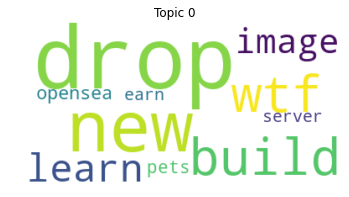

In [41]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()
create_wordcloud(ldana,0
                 )

In [42]:
from gensim import corpora
word2id = dict((k, v) for k, v in cvna.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

In [43]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = models.LdaMulticore(corpus=corpus, num_topics=k, id2word=dictionary, passes=10,alpha=a,
                                           eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus,dictionary=dictionary, coherence='u_mass')
    return coherence_model_lda.get_coherence()

In [44]:
from gensim import models
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

model_results = {
                 'Topics': [],
                 'Coherence': []
                }

if 1 == 1:
    # iterate through number of topics
    for k in topics_range:
            # get the coherence score for the given parameters
            print(k)
            cv = compute_coherence_values(corpus=corpusna, dictionary=d,
                                                  k=k, a=0.5, b=0.5)
            # Save the results
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)

2
3
4
5
6
7
8
9


In [45]:
results = pd.DataFrame(model_results)

In [46]:
grouped = (results.groupby(['Topics'], as_index=False)).mean()

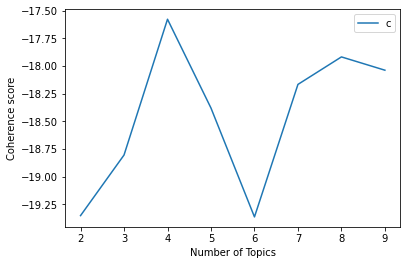

In [47]:
import matplotlib.pyplot as plt
plt.plot(grouped['Topics'], grouped['Coherence'])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
results.to_csv("../data/resultsLDA062022.csv",index=False)